# Day 1: Regression
## Ridge Regression

In this notebook we are going to implement ridge regression. You will be provided with some already complete code as well as some code that you should complete yourself. In particular, you will have to:

* Complete the function `ridgeRegrNEW(X_train, y_train, alpha,X_test)` to implement ridge regression algorithm.
* Complete the function `ridgeRegrCV(X_train, y_train, alpha,X_test)` that will make use of the pre-built implementation of Ridge regression with cross validation to select the best L2-penalty. Experiment with different cross validation methods. 



# Import libraries
The required libraries for this notebook are pandas, sklearn, numpy and matplotlib.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import *
import pandas as pd
# from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

# Load the data
The data we are using is from Boston house-prices dataset, which we can access directly from the scikit learn library . It consists of 506 data points and 13 features.

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
newX = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
newY = raw_df.values[1::2, 2]


In [3]:
X_train,X_test,y_train,y_test=train_test_split(newX,newY,test_size=0.3,random_state=3) 
#test_size= should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#everytime you run it without specifying random_state, you will get a different result, this is expected behavior
#print (len(X_test), len(y_test))

print('train set: {}  | test set: {}'.format(round(len(y_train)/(len(newX)*1.0),2),
                                                       round(len(y_test)/(len(newX)*1.0),2)))

train set: 0.7  | test set: 0.3


# Use ridge regression from a library
We will first see how ridge regression can be implemented using already available functions from the scikit-learn library.

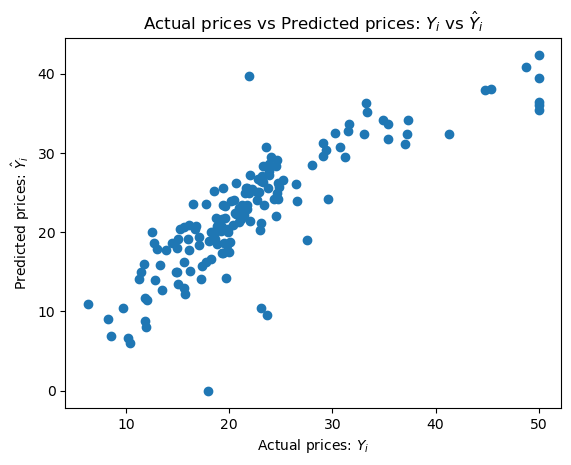

In [4]:
def ridgeRegr(X_train, y_train, X_test):

    #Create linear regression object with a ridge coefficient 0.1
    ridge_regr_model = Ridge(alpha=0.1,fit_intercept=True)
    ridge_regr_model.fit(X_train, y_train) # Fit Ridge regression model


    Y_pred = ridge_regr_model.predict(X_test)
    #print (Y_pred)
    return Y_pred

Y_pred=ridgeRegr(X_train, y_train, X_test)

plt.scatter(y_test, Y_pred)
plt.xlabel("Actual prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show() #Ideally, the scatter plot should create a linear line. Since the model does not fit 100%, the scatter plot is not creating a linear line.



# Implement your own ridge regression function

You will be given the `paramEstimate(xTrain, yTrain, alpha)` function estimates the parameters of the ridge regressor.
Remember that ridge regression solves a linear regression problem based on a loss function consisting of the sum of squared error and a regularizer. In particular, the loss function is given by:

\begin{align}
||y - \sum{\beta_j}x_j||^2 + λ\sum{\beta_j}^2
\end{align}



Note: we train on `X_train` and `y_train`!

In [5]:
def paramEstimate(X_train, y_train, alpha):
    n, d = X_train.shape
    I = np.identity(d)
    L = np.dot(alpha, I) + np.dot(X_train.transpose(), X_train)
    L_1 = np.linalg.inv(L)
    w_rr = L_1.dot(X_train.transpose()).dot(y_train)
    return w_rr


def ridgeRegrNEW(xTrain, yTrain, alpha,X_test):
    w_rr=paramEstimate(xTrain, yTrain, alpha)
    y_pred1=np.dot(X_test,w_rr)
    return y_pred1



(354, 14)
(152, 14)


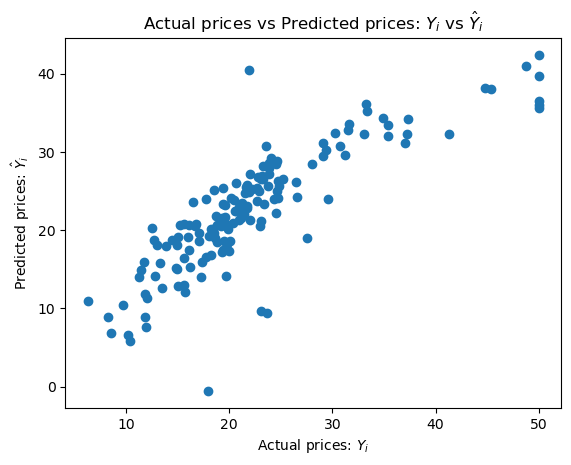

In [6]:
intercept = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((intercept, X_train), axis=1)
print(X_train.shape)
intercept = np.ones((X_test.shape[0], 1))
X_test = np.concatenate((intercept, X_test), axis=1)
print(X_test.shape)


y_pred = ridgeRegrNEW(X_train, y_train, 0.1,X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Actual prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()


In [7]:
#NEW SOLUTION

class RidgeRegression(object):
    def __init__(self, lmbda=0.1):
        self.lmbda = lmbda

    def fit(self, X, y):
        C = X.T.dot(X) + self.lmbda*np.eye(X.shape[1])
        self.w = np.linalg.inv(C).dot(X.T.dot(y))

    def predict(self, X):
        return X.dot(self.w)

    def get_params(self, deep=True):
        return {"lmbda": self.lmbda}

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self
from sklearn.model_selection import GridSearchCV
    
ridge = RidgeRegression()
param_grid = [{"lmbda": 2.0**np.arange(-5, 10)}]
learner = GridSearchCV(ridge, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=0)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred)
print(ridge_error)

22.62088976397157


 You can compare the two models using MSE:

In [8]:
mse = mean_squared_error(y_test, Y_pred) # check the level of error of a model
print('Mean Squared Error (MSE) on test set (built-in model): '+str(mse))
mse2=mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE) on test set (from scratch model): '+ str(mse2))

Mean Squared Error (MSE) on test set (built-in model): 22.563213788504807
Mean Squared Error (MSE) on test set (from scratch model): 22.62088976397157


# Cross-validation for selecting the ridge regressor hyper-parameter  

`Ridge()` function from scikit-learn library has a hyper-parameter **alpha**  (we also refer to this hyper-parameter as λ) that is used to tune the model. Instead of choosing alpha manually, it is better to use cross-validation to optimize the selection of the hyper-parameter. 

Each alpha corresponds to a vector of thirteen ridge regression coefficients. We will create a 13×5 matrix to store the various combinations of hyper parameters and associated ridge regression coefficients (13 rows for our 13 predictors and 5 columns for our 5 generated alphas). You can of course change the number of generated alphas.


In [9]:
# generate a range of alpha values and put them in a numpy array
#r_alphas = 10**np.linspace(10,-2,100)*0.5
r_alphas = [0.001, 0.01, 0.1, 1, 10]
#print(r_alphas)


 
 Make use of `RidgeCV()`, which is the cross-validated `Ridge()` function from scikit-learn. 

In [10]:
def ridgeRegrCVPredict(X_train, y_train, r_alphas,X_test):
    
    ridgecv = RidgeCV(alphas = r_alphas, fit_intercept=True)
    ridgecv.fit(X_train, y_train)
    print('Best alpha value: '+str(ridgecv.alpha_))

    Y_pred_cv = ridgecv.predict(X_test)
    # alternatively you could:
    #ridge = Ridge(alpha = ridgecv.alpha_)
    #ridge.fit(X_train, y_train)
    #Y_pred_cv=ridge.predict(X_test)
    return Y_pred_cv


Test your results:

Best alpha value: 0.1
Mean Squared Error (MSE) on test set (built-in cross-validation): 22.56321381727669


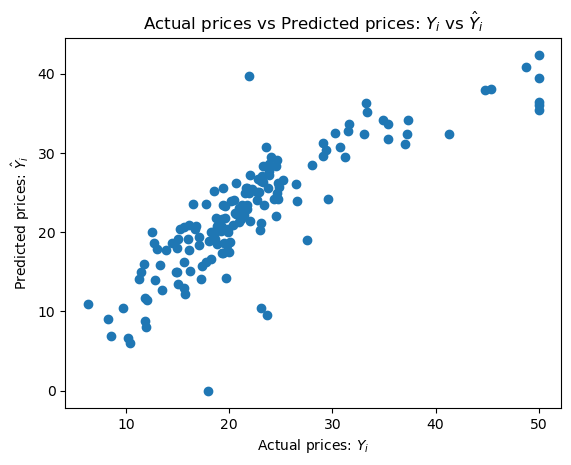

In [11]:
Y_pred_cv =  ridgeRegrCVPredict(X_train, y_train, r_alphas,X_test)
mse_cv=mean_squared_error(y_test,Y_pred_cv)
print('Mean Squared Error (MSE) on test set (built-in cross-validation): '+str(mse_cv))

plt.scatter(y_test, Y_pred_cv)
plt.xlabel("Actual prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()
